In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# ---------------------------------------
# 1. Data Loading and Inspection
# ---------------------------------------
train_data = pd.read_csv('/content/Google_Stock_Price_Train.csv')
test_data = pd.read_csv('/content/Google_Stock_Price_Test.csv')

print("Training Data Sample:\n", train_data.head())
print("Test Data Sample:\n", test_data.head())
print("Missing values in training data:\n", train_data.isnull().sum())

Training Data Sample:
        Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800
Test Data Sample:
        Date    Open    High     Low   Close     Volume
0  1/3/2017  778.81  789.63  775.80  786.14  1,657,300
1  1/4/2017  788.36  791.34  783.16  786.90  1,073,000
2  1/5/2017  786.08  794.48  785.02  794.02  1,335,200
3  1/6/2017  795.26  807.90  792.20  806.15  1,640,200
4  1/9/2017  806.40  809.97  802.83  806.65  1,272,400
Missing values in training data:
 Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [ ]:
# ---------------------------------------
# 2. Data Cleaning and Preprocessing
# ---------------------------------------
features = ['Open', 'High', 'Low', 'Close']

# Convert columns that are object type with commas into float
for feature in features:
    if train_data[feature].dtype == 'object':
        train_data[feature] = train_data[feature].str.replace(',', '', regex=True).astype(float)
    if test_data[feature].dtype == 'object':
        test_data[feature] = test_data[feature].str.replace(',', '', regex=True).astype(float)

training_set = train_data[features].values
test_set = test_data[features].values

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = scaler.fit_transform(training_set)

In [ ]:
# ---------------------------------------
# 3. Fixed-length Sequence Creation (Sliding Window)
# ---------------------------------------
N = 30  # number of past days to use as input
M = 1   # number of future days to predict

X, y = [], []
for i in range(N, len(training_set_scaled) - M + 1):
    X.append(training_set_scaled[i-N:i, :])
    y.append(training_set_scaled[i:i+M, :])

X, y = np.array(X), np.array(y)

# Split into training and validation sets (time-aware)
split = int(len(X) * 0.8)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

In [ ]:
# ---------------------------------------
# 4. Dataset and DataLoader
# ---------------------------------------
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = StockDataset(X_train, y_train)
val_dataset = StockDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# ---------------------------------------
# 5. LSTM Model Definition
# ---------------------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: [B, T, input_dim]
        out, _ = self.lstm(x)  # out: [B, T, hidden_dim]
        out = out[:, -1, :]    # Take the last time step
        out = self.fc(out)     # Map to output_dim
        return out

In [ ]:
# ---------------------------------------
# 6. Custom Asymmetric Loss Function
# ---------------------------------------
class AsymmetricLoss(nn.Module):
    def __init__(self, ratio=2.0):
        super(AsymmetricLoss, self).__init__()
        self.ratio = ratio

    def forward(self, pred, target):
        diff = target - pred
        loss = torch.mean(torch.where(diff > 0, self.ratio * diff**2, diff**2))
        return loss

In [ ]:
# ---------------------------------------
# 7. Training Function with Metric Logging
# ---------------------------------------
def train_and_validate(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=30):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_state = None

    for epoch in range(epochs):
        # Training
        model.train()
        running_train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.view(outputs.shape))
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch.view(outputs.shape))
                running_val_loss += loss.item()

        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return best_state, best_val_loss, train_losses, val_losses

In [ ]:
# ---------------------------------------
# 8. Hyperparameter Tuning with Optuna
# ---------------------------------------
def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 50, 300)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    ratio = trial.suggest_float('asymmetric_ratio', 1.0, 5.0)

    model = LSTMModel(input_dim=len(features), hidden_dim=hidden_dim, output_dim=len(features)).to(device)
    criterion = AsymmetricLoss(ratio=ratio)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5)

    # Shorter training for tuning
    best_state, best_val_loss, _, _ = train_and_validate(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=30)
    return best_val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40)
print("Best hyperparameters:", study.best_params)

[I 2024-12-06 23:37:44,617] A new study created in memory with name: no-name-f39cc9ff-3a54-49a8-b49b-39580eab5091


Epoch 1/30, Train Loss: 0.2145, Val Loss: 0.5020
Epoch 2/30, Train Loss: 0.0422, Val Loss: 0.0057
Epoch 3/30, Train Loss: 0.0453, Val Loss: 0.0088
Epoch 4/30, Train Loss: 0.0331, Val Loss: 0.0059
Epoch 5/30, Train Loss: 0.0229, Val Loss: 0.0029
Epoch 6/30, Train Loss: 0.0196, Val Loss: 0.0032
Epoch 7/30, Train Loss: 0.0181, Val Loss: 0.0057
Epoch 8/30, Train Loss: 0.0159, Val Loss: 0.0169
Epoch 9/30, Train Loss: 0.0123, Val Loss: 0.0334
Epoch 10/30, Train Loss: 0.0084, Val Loss: 0.0262
Epoch 11/30, Train Loss: 0.0069, Val Loss: 0.0131
Epoch 12/30, Train Loss: 0.0048, Val Loss: 0.0123
Epoch 13/30, Train Loss: 0.0043, Val Loss: 0.0115
Epoch 14/30, Train Loss: 0.0041, Val Loss: 0.0107
Epoch 15/30, Train Loss: 0.0040, Val Loss: 0.0101
Epoch 16/30, Train Loss: 0.0040, Val Loss: 0.0097
Epoch 17/30, Train Loss: 0.0039, Val Loss: 0.0093
Epoch 18/30, Train Loss: 0.0038, Val Loss: 0.0092
Epoch 19/30, Train Loss: 0.0038, Val Loss: 0.0092
Epoch 20/30, Train Loss: 0.0038, Val Loss: 0.0091
Epoch 21/

[I 2024-12-06 23:37:47,241] Trial 0 finished with value: 0.002862760884454474 and parameters: {'hidden_dim': 71, 'lr': 0.0003698168274463182, 'weight_decay': 3.51470808252072e-05, 'asymmetric_ratio': 1.28395733826436}. Best is trial 0 with value: 0.002862760884454474.


Epoch 29/30, Train Loss: 0.0037, Val Loss: 0.0089
Epoch 30/30, Train Loss: 0.0037, Val Loss: 0.0089
Epoch 1/30, Train Loss: 0.0281, Val Loss: 0.0607
Epoch 2/30, Train Loss: 0.0887, Val Loss: 0.0119
Epoch 3/30, Train Loss: 0.0532, Val Loss: 0.0119
Epoch 4/30, Train Loss: 0.0333, Val Loss: 0.0058
Epoch 5/30, Train Loss: 0.0221, Val Loss: 0.0008
Epoch 6/30, Train Loss: 0.0170, Val Loss: 0.0028
Epoch 7/30, Train Loss: 0.0186, Val Loss: 0.0024
Epoch 8/30, Train Loss: 0.0189, Val Loss: 0.0013
Epoch 9/30, Train Loss: 0.0049, Val Loss: 0.0011
Epoch 10/30, Train Loss: 0.0048, Val Loss: 0.0006
Epoch 11/30, Train Loss: 0.0033, Val Loss: 0.0024
Epoch 12/30, Train Loss: 0.0025, Val Loss: 0.0033
Epoch 13/30, Train Loss: 0.0019, Val Loss: 0.0013
Epoch 14/30, Train Loss: 0.0028, Val Loss: 0.0019
Epoch 15/30, Train Loss: 0.0055, Val Loss: 0.0052
Epoch 16/30, Train Loss: 0.0050, Val Loss: 0.0070
Epoch 17/30, Train Loss: 0.0046, Val Loss: 0.0015
Epoch 18/30, Train Loss: 0.0013, Val Loss: 0.0008
Epoch 19/

[I 2024-12-06 23:37:50,214] Trial 1 finished with value: 0.000550333770661382 and parameters: {'hidden_dim': 99, 'lr': 0.0019414535000848723, 'weight_decay': 0.0007702851591586432, 'asymmetric_ratio': 1.7144540619231292}. Best is trial 1 with value: 0.000550333770661382.


Epoch 29/30, Train Loss: 0.0008, Val Loss: 0.0006
Epoch 30/30, Train Loss: 0.0008, Val Loss: 0.0006
Epoch 1/30, Train Loss: 0.0404, Val Loss: 0.0264
Epoch 2/30, Train Loss: 0.0654, Val Loss: 0.0048
Epoch 3/30, Train Loss: 0.0391, Val Loss: 0.0046
Epoch 4/30, Train Loss: 0.0243, Val Loss: 0.0038
Epoch 5/30, Train Loss: 0.0180, Val Loss: 0.0147
Epoch 6/30, Train Loss: 0.0233, Val Loss: 0.0018
Epoch 7/30, Train Loss: 0.0118, Val Loss: 0.0049
Epoch 8/30, Train Loss: 0.0125, Val Loss: 0.0030
Epoch 9/30, Train Loss: 0.0134, Val Loss: 0.0008
Epoch 10/30, Train Loss: 0.0026, Val Loss: 0.0007
Epoch 11/30, Train Loss: 0.0033, Val Loss: 0.0005
Epoch 12/30, Train Loss: 0.0022, Val Loss: 0.0024
Epoch 13/30, Train Loss: 0.0049, Val Loss: 0.0093
Epoch 14/30, Train Loss: 0.0066, Val Loss: 0.0072
Epoch 15/30, Train Loss: 0.0051, Val Loss: 0.0014
Epoch 16/30, Train Loss: 0.0036, Val Loss: 0.0036
Epoch 17/30, Train Loss: 0.0114, Val Loss: 0.0270
Epoch 18/30, Train Loss: 0.0043, Val Loss: 0.0122
Epoch 19/

[I 2024-12-06 23:37:53,932] Trial 2 finished with value: 0.0003897624756064033 and parameters: {'hidden_dim': 251, 'lr': 0.0013135010638940336, 'weight_decay': 6.540342495786065e-05, 'asymmetric_ratio': 1.0769955179474873}. Best is trial 2 with value: 0.0003897624756064033.


Epoch 29/30, Train Loss: 0.0006, Val Loss: 0.0005
Epoch 30/30, Train Loss: 0.0006, Val Loss: 0.0005
Epoch 1/30, Train Loss: 0.1172, Val Loss: 0.0483
Epoch 2/30, Train Loss: 0.0705, Val Loss: 0.0248
Epoch 3/30, Train Loss: 0.0464, Val Loss: 0.0265
Epoch 4/30, Train Loss: 0.0319, Val Loss: 0.0159
Epoch 5/30, Train Loss: 0.0261, Val Loss: 0.0076
Epoch 6/30, Train Loss: 0.0217, Val Loss: 0.0029
Epoch 7/30, Train Loss: 0.0204, Val Loss: 0.0306
Epoch 8/30, Train Loss: 0.0266, Val Loss: 0.0034
Epoch 9/30, Train Loss: 0.0121, Val Loss: 0.0155
Epoch 10/30, Train Loss: 0.0059, Val Loss: 0.0115
Epoch 11/30, Train Loss: 0.0156, Val Loss: 0.0022
Epoch 12/30, Train Loss: 0.0056, Val Loss: 0.0128
Epoch 13/30, Train Loss: 0.0046, Val Loss: 0.0095
Epoch 14/30, Train Loss: 0.0096, Val Loss: 0.0022
Epoch 15/30, Train Loss: 0.0036, Val Loss: 0.0085
Epoch 16/30, Train Loss: 0.0040, Val Loss: 0.0063
Epoch 17/30, Train Loss: 0.0065, Val Loss: 0.0039
Epoch 18/30, Train Loss: 0.0069, Val Loss: 0.0070
Epoch 19/

[I 2024-12-06 23:37:57,070] Trial 3 finished with value: 0.0022148557764012367 and parameters: {'hidden_dim': 139, 'lr': 0.0004352426693018247, 'weight_decay': 1.0127224164695107e-05, 'asymmetric_ratio': 1.4437037517391018}. Best is trial 2 with value: 0.0003897624756064033.


Epoch 30/30, Train Loss: 0.0020, Val Loss: 0.0041
Epoch 1/30, Train Loss: 0.5664, Val Loss: 1.5729
Epoch 2/30, Train Loss: 0.1948, Val Loss: 0.0281
Epoch 3/30, Train Loss: 0.1000, Val Loss: 0.0617
Epoch 4/30, Train Loss: 0.0630, Val Loss: 0.0655
Epoch 5/30, Train Loss: 0.0520, Val Loss: 0.0512
Epoch 6/30, Train Loss: 0.0471, Val Loss: 0.0436
Epoch 7/30, Train Loss: 0.0433, Val Loss: 0.0406
Epoch 8/30, Train Loss: 0.0403, Val Loss: 0.0411
Epoch 9/30, Train Loss: 0.0339, Val Loss: 0.0434
Epoch 10/30, Train Loss: 0.0338, Val Loss: 0.0430
Epoch 11/30, Train Loss: 0.0336, Val Loss: 0.0431
Epoch 12/30, Train Loss: 0.0334, Val Loss: 0.0433
Epoch 13/30, Train Loss: 0.0333, Val Loss: 0.0434
Epoch 14/30, Train Loss: 0.0331, Val Loss: 0.0435
Epoch 15/30, Train Loss: 0.0324, Val Loss: 0.0434
Epoch 16/30, Train Loss: 0.0324, Val Loss: 0.0433
Epoch 17/30, Train Loss: 0.0324, Val Loss: 0.0432
Epoch 18/30, Train Loss: 0.0324, Val Loss: 0.0431
Epoch 19/30, Train Loss: 0.0323, Val Loss: 0.0430
Epoch 20/

[I 2024-12-06 23:38:00,727] Trial 4 finished with value: 0.028127966914325953 and parameters: {'hidden_dim': 168, 'lr': 0.00014433144512601082, 'weight_decay': 6.984153621211195e-05, 'asymmetric_ratio': 3.3613578730477545}. Best is trial 2 with value: 0.0003897624756064033.


Epoch 30/30, Train Loss: 0.0322, Val Loss: 0.0429
Epoch 1/30, Train Loss: 0.0223, Val Loss: 0.0438
Epoch 2/30, Train Loss: 0.0768, Val Loss: 0.0103
Epoch 3/30, Train Loss: 0.0595, Val Loss: 0.0167
Epoch 4/30, Train Loss: 0.0363, Val Loss: 0.0085
Epoch 5/30, Train Loss: 0.0309, Val Loss: 0.0039
Epoch 6/30, Train Loss: 0.0310, Val Loss: 0.0024
Epoch 7/30, Train Loss: 0.0222, Val Loss: 0.0018
Epoch 8/30, Train Loss: 0.0183, Val Loss: 0.0048
Epoch 9/30, Train Loss: 0.0168, Val Loss: 0.0016
Epoch 10/30, Train Loss: 0.0203, Val Loss: 0.0035
Epoch 11/30, Train Loss: 0.0227, Val Loss: 0.0039
Epoch 12/30, Train Loss: 0.0157, Val Loss: 0.0013
Epoch 13/30, Train Loss: 0.0066, Val Loss: 0.0025
Epoch 14/30, Train Loss: 0.0210, Val Loss: 0.0010
Epoch 15/30, Train Loss: 0.0075, Val Loss: 0.0037
Epoch 16/30, Train Loss: 0.0013, Val Loss: 0.0014
Epoch 17/30, Train Loss: 0.0038, Val Loss: 0.0024
Epoch 18/30, Train Loss: 0.0018, Val Loss: 0.0005
Epoch 19/30, Train Loss: 0.0012, Val Loss: 0.0004
Epoch 20/

[I 2024-12-06 23:38:04,018] Trial 5 finished with value: 0.0003908182006853167 and parameters: {'hidden_dim': 295, 'lr': 0.001771488195450595, 'weight_decay': 7.843832151934584e-06, 'asymmetric_ratio': 1.7754142912610416}. Best is trial 2 with value: 0.0003897624756064033.


Epoch 30/30, Train Loss: 0.0054, Val Loss: 0.0005
Epoch 1/30, Train Loss: 0.1738, Val Loss: 0.1807
Epoch 2/30, Train Loss: 0.0838, Val Loss: 0.0416
Epoch 3/30, Train Loss: 0.0726, Val Loss: 0.0427
Epoch 4/30, Train Loss: 0.0568, Val Loss: 0.0424
Epoch 5/30, Train Loss: 0.0480, Val Loss: 0.0400
Epoch 6/30, Train Loss: 0.0475, Val Loss: 0.0354
Epoch 7/30, Train Loss: 0.0542, Val Loss: 0.0219
Epoch 8/30, Train Loss: 0.0530, Val Loss: 0.0268
Epoch 9/30, Train Loss: 0.0433, Val Loss: 0.0111
Epoch 10/30, Train Loss: 0.0294, Val Loss: 0.0116
Epoch 11/30, Train Loss: 0.0153, Val Loss: 0.0026
Epoch 12/30, Train Loss: 0.0343, Val Loss: 0.0247
Epoch 13/30, Train Loss: 0.0110, Val Loss: 0.0057
Epoch 14/30, Train Loss: 0.0074, Val Loss: 0.0205
Epoch 15/30, Train Loss: 0.0253, Val Loss: 0.0177
Epoch 16/30, Train Loss: 0.0174, Val Loss: 0.0054
Epoch 17/30, Train Loss: 0.0145, Val Loss: 0.0196
Epoch 18/30, Train Loss: 0.0099, Val Loss: 0.0089
Epoch 19/30, Train Loss: 0.0081, Val Loss: 0.0072
Epoch 20/

[I 2024-12-06 23:38:07,106] Trial 6 finished with value: 0.002639753802213818 and parameters: {'hidden_dim': 130, 'lr': 0.0006855126271611092, 'weight_decay': 1.3213684351664608e-05, 'asymmetric_ratio': 4.1142612387365}. Best is trial 2 with value: 0.0003897624756064033.


Epoch 28/30, Train Loss: 0.0034, Val Loss: 0.0047
Epoch 29/30, Train Loss: 0.0034, Val Loss: 0.0047
Epoch 30/30, Train Loss: 0.0033, Val Loss: 0.0047
Epoch 1/30, Train Loss: 0.0344, Val Loss: 0.0385
Epoch 2/30, Train Loss: 0.1160, Val Loss: 0.0621
Epoch 3/30, Train Loss: 0.0680, Val Loss: 0.0403
Epoch 4/30, Train Loss: 0.0416, Val Loss: 0.0250
Epoch 5/30, Train Loss: 0.0336, Val Loss: 0.0107
Epoch 6/30, Train Loss: 0.0318, Val Loss: 0.0069
Epoch 7/30, Train Loss: 0.0451, Val Loss: 0.0207
Epoch 8/30, Train Loss: 0.0293, Val Loss: 0.0087
Epoch 9/30, Train Loss: 0.0118, Val Loss: 0.0046
Epoch 10/30, Train Loss: 0.0193, Val Loss: 0.0092
Epoch 11/30, Train Loss: 0.0119, Val Loss: 0.0021
Epoch 12/30, Train Loss: 0.0034, Val Loss: 0.0014
Epoch 13/30, Train Loss: 0.0035, Val Loss: 0.0049
Epoch 14/30, Train Loss: 0.0078, Val Loss: 0.0083
Epoch 15/30, Train Loss: 0.0063, Val Loss: 0.0023
Epoch 16/30, Train Loss: 0.0064, Val Loss: 0.0073
Epoch 17/30, Train Loss: 0.0043, Val Loss: 0.0015
Epoch 18/

[I 2024-12-06 23:38:10,764] Trial 7 finished with value: 0.0005196150123083498 and parameters: {'hidden_dim': 165, 'lr': 0.0017517569770659294, 'weight_decay': 0.0002303364507646961, 'asymmetric_ratio': 2.836612783450417}. Best is trial 2 with value: 0.0003897624756064033.


Epoch 29/30, Train Loss: 0.0009, Val Loss: 0.0007
Epoch 30/30, Train Loss: 0.0009, Val Loss: 0.0007
Epoch 1/30, Train Loss: 0.0264, Val Loss: 0.0588
Epoch 2/30, Train Loss: 0.0870, Val Loss: 0.0187
Epoch 3/30, Train Loss: 0.0455, Val Loss: 0.0157
Epoch 4/30, Train Loss: 0.0283, Val Loss: 0.0043
Epoch 5/30, Train Loss: 0.0213, Val Loss: 0.0067
Epoch 6/30, Train Loss: 0.0191, Val Loss: 0.0104
Epoch 7/30, Train Loss: 0.0238, Val Loss: 0.0022
Epoch 8/30, Train Loss: 0.0112, Val Loss: 0.0052
Epoch 9/30, Train Loss: 0.0040, Val Loss: 0.0045
Epoch 10/30, Train Loss: 0.0117, Val Loss: 0.0006
Epoch 11/30, Train Loss: 0.0071, Val Loss: 0.0025
Epoch 12/30, Train Loss: 0.0035, Val Loss: 0.0008
Epoch 13/30, Train Loss: 0.0036, Val Loss: 0.0012
Epoch 14/30, Train Loss: 0.0022, Val Loss: 0.0024
Epoch 15/30, Train Loss: 0.0014, Val Loss: 0.0011
Epoch 16/30, Train Loss: 0.0035, Val Loss: 0.0068
Epoch 17/30, Train Loss: 0.0028, Val Loss: 0.0018
Epoch 18/30, Train Loss: 0.0014, Val Loss: 0.0007
Epoch 19/

[I 2024-12-06 23:38:14,054] Trial 8 finished with value: 0.0006286254720180295 and parameters: {'hidden_dim': 234, 'lr': 0.0009853610843180013, 'weight_decay': 1.945752731926878e-06, 'asymmetric_ratio': 1.212813124275982}. Best is trial 2 with value: 0.0003897624756064033.


Epoch 29/30, Train Loss: 0.0008, Val Loss: 0.0008
Epoch 30/30, Train Loss: 0.0008, Val Loss: 0.0008
Epoch 1/30, Train Loss: 0.0395, Val Loss: 0.0860
Epoch 2/30, Train Loss: 0.0757, Val Loss: 0.0065
Epoch 3/30, Train Loss: 0.1067, Val Loss: 0.0334
Epoch 4/30, Train Loss: 0.0851, Val Loss: 0.0097
Epoch 5/30, Train Loss: 0.1006, Val Loss: 0.0181
Epoch 6/30, Train Loss: 0.1751, Val Loss: 0.0587
Epoch 7/30, Train Loss: 0.1775, Val Loss: 0.1357
Epoch 8/30, Train Loss: 0.1486, Val Loss: 0.1173
Epoch 9/30, Train Loss: 0.1770, Val Loss: 0.2921
Epoch 10/30, Train Loss: 0.1220, Val Loss: 0.3364
Epoch 11/30, Train Loss: 0.1134, Val Loss: 0.3113
Epoch 12/30, Train Loss: 0.1037, Val Loss: 0.2253
Epoch 13/30, Train Loss: 0.0847, Val Loss: 0.1122
Epoch 14/30, Train Loss: 0.0658, Val Loss: 0.0496
Epoch 15/30, Train Loss: 0.0494, Val Loss: 0.0486
Epoch 16/30, Train Loss: 0.0472, Val Loss: 0.0480
Epoch 17/30, Train Loss: 0.0457, Val Loss: 0.0454
Epoch 18/30, Train Loss: 0.0446, Val Loss: 0.0424
Epoch 19/

[I 2024-12-06 23:38:17,366] Trial 9 finished with value: 0.006502387404907495 and parameters: {'hidden_dim': 294, 'lr': 0.007060621587393327, 'weight_decay': 3.7645639816956485e-05, 'asymmetric_ratio': 4.329342428869225}. Best is trial 2 with value: 0.0003897624756064033.


Epoch 29/30, Train Loss: 0.0415, Val Loss: 0.0360
Epoch 30/30, Train Loss: 0.0415, Val Loss: 0.0360
Epoch 1/30, Train Loss: 0.0176, Val Loss: 0.0039
Epoch 2/30, Train Loss: 0.0533, Val Loss: 0.0120
Epoch 3/30, Train Loss: 0.1029, Val Loss: 0.0305
Epoch 4/30, Train Loss: 0.0463, Val Loss: 0.0189
Epoch 5/30, Train Loss: 0.0500, Val Loss: 0.0086
Epoch 6/30, Train Loss: 0.0572, Val Loss: 0.0211
Epoch 7/30, Train Loss: 0.0382, Val Loss: 0.0216
Epoch 8/30, Train Loss: 0.0237, Val Loss: 0.0194
Epoch 9/30, Train Loss: 0.0135, Val Loss: 0.0065
Epoch 10/30, Train Loss: 0.0088, Val Loss: 0.0042
Epoch 11/30, Train Loss: 0.0062, Val Loss: 0.0030
Epoch 12/30, Train Loss: 0.0046, Val Loss: 0.0023
Epoch 13/30, Train Loss: 0.0033, Val Loss: 0.0018
Epoch 14/30, Train Loss: 0.0023, Val Loss: 0.0015
Epoch 15/30, Train Loss: 0.0015, Val Loss: 0.0011
Epoch 16/30, Train Loss: 0.0010, Val Loss: 0.0009
Epoch 17/30, Train Loss: 0.0008, Val Loss: 0.0008
Epoch 18/30, Train Loss: 0.0007, Val Loss: 0.0007
Epoch 19/

[I 2024-12-06 23:38:20,635] Trial 10 finished with value: 0.0004677775505115278 and parameters: {'hidden_dim': 231, 'lr': 0.007598312148302885, 'weight_decay': 0.0001776488355058983, 'asymmetric_ratio': 2.628532793831823}. Best is trial 2 with value: 0.0003897624756064033.


Epoch 29/30, Train Loss: 0.0006, Val Loss: 0.0005
Epoch 30/30, Train Loss: 0.0006, Val Loss: 0.0005
Epoch 1/30, Train Loss: 0.0246, Val Loss: 0.0235
Epoch 2/30, Train Loss: 0.0754, Val Loss: 0.0219
Epoch 3/30, Train Loss: 0.0616, Val Loss: 0.0089
Epoch 4/30, Train Loss: 0.0532, Val Loss: 0.0174
Epoch 5/30, Train Loss: 0.0387, Val Loss: 0.0089
Epoch 6/30, Train Loss: 0.0332, Val Loss: 0.0021
Epoch 7/30, Train Loss: 0.0313, Val Loss: 0.0112
Epoch 8/30, Train Loss: 0.0249, Val Loss: 0.0103
Epoch 9/30, Train Loss: 0.0199, Val Loss: 0.0045
Epoch 10/30, Train Loss: 0.0101, Val Loss: 0.0063
Epoch 11/30, Train Loss: 0.0134, Val Loss: 0.0013
Epoch 12/30, Train Loss: 0.0116, Val Loss: 0.0054
Epoch 13/30, Train Loss: 0.0066, Val Loss: 0.0008
Epoch 14/30, Train Loss: 0.0134, Val Loss: 0.0135
Epoch 15/30, Train Loss: 0.0081, Val Loss: 0.0015
Epoch 16/30, Train Loss: 0.0047, Val Loss: 0.0035
Epoch 17/30, Train Loss: 0.0024, Val Loss: 0.0003
Epoch 18/30, Train Loss: 0.0013, Val Loss: 0.0017
Epoch 19/

[I 2024-12-06 23:38:23,952] Trial 11 finished with value: 0.00034915228752652183 and parameters: {'hidden_dim': 298, 'lr': 0.002899082539195223, 'weight_decay': 2.4543856390741694e-06, 'asymmetric_ratio': 2.2101995131230447}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 29/30, Train Loss: 0.0005, Val Loss: 0.0005
Epoch 30/30, Train Loss: 0.0005, Val Loss: 0.0005
Epoch 1/30, Train Loss: 0.0308, Val Loss: 0.0259
Epoch 2/30, Train Loss: 0.0763, Val Loss: 0.0175
Epoch 3/30, Train Loss: 0.0639, Val Loss: 0.0127
Epoch 4/30, Train Loss: 0.0495, Val Loss: 0.0109
Epoch 5/30, Train Loss: 0.0389, Val Loss: 0.0061
Epoch 6/30, Train Loss: 0.0355, Val Loss: 0.0026
Epoch 7/30, Train Loss: 0.0283, Val Loss: 0.0035
Epoch 8/30, Train Loss: 0.0222, Val Loss: 0.0031
Epoch 9/30, Train Loss: 0.0106, Val Loss: 0.0020
Epoch 10/30, Train Loss: 0.0080, Val Loss: 0.0046
Epoch 11/30, Train Loss: 0.0082, Val Loss: 0.0021
Epoch 12/30, Train Loss: 0.0081, Val Loss: 0.0101
Epoch 13/30, Train Loss: 0.0234, Val Loss: 0.0156
Epoch 14/30, Train Loss: 0.0139, Val Loss: 0.0035
Epoch 15/30, Train Loss: 0.0063, Val Loss: 0.0040
Epoch 16/30, Train Loss: 0.0111, Val Loss: 0.0104
Epoch 17/30, Train Loss: 0.0056, Val Loss: 0.0081
Epoch 18/30, Train Loss: 0.0033, Val Loss: 0.0061
Epoch 19/

[I 2024-12-06 23:38:27,353] Trial 12 finished with value: 0.0019871681470249314 and parameters: {'hidden_dim': 239, 'lr': 0.0036987656760323986, 'weight_decay': 1.5271395026334217e-06, 'asymmetric_ratio': 2.293302763419026}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 29/30, Train Loss: 0.0007, Val Loss: 0.0025
Epoch 30/30, Train Loss: 0.0007, Val Loss: 0.0025
Epoch 1/30, Train Loss: 0.0221, Val Loss: 0.0369
Epoch 2/30, Train Loss: 0.0811, Val Loss: 0.0172
Epoch 3/30, Train Loss: 0.0606, Val Loss: 0.0073
Epoch 4/30, Train Loss: 0.0515, Val Loss: 0.0088
Epoch 5/30, Train Loss: 0.0418, Val Loss: 0.0047
Epoch 6/30, Train Loss: 0.0355, Val Loss: 0.0040
Epoch 7/30, Train Loss: 0.0228, Val Loss: 0.0033
Epoch 8/30, Train Loss: 0.0172, Val Loss: 0.0018
Epoch 9/30, Train Loss: 0.0132, Val Loss: 0.0021
Epoch 10/30, Train Loss: 0.0069, Val Loss: 0.0049
Epoch 11/30, Train Loss: 0.0077, Val Loss: 0.0040
Epoch 12/30, Train Loss: 0.0051, Val Loss: 0.0016
Epoch 13/30, Train Loss: 0.0077, Val Loss: 0.0010
Epoch 14/30, Train Loss: 0.0028, Val Loss: 0.0033
Epoch 15/30, Train Loss: 0.0051, Val Loss: 0.0011
Epoch 16/30, Train Loss: 0.0021, Val Loss: 0.0018
Epoch 17/30, Train Loss: 0.0022, Val Loss: 0.0006
Epoch 18/30, Train Loss: 0.0036, Val Loss: 0.0034
Epoch 19/

[I 2024-12-06 23:38:30,712] Trial 13 finished with value: 0.0005605223959719297 and parameters: {'hidden_dim': 261, 'lr': 0.0034450020413941147, 'weight_decay': 3.6245823031154636e-06, 'asymmetric_ratio': 2.1339266351272688}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 29/30, Train Loss: 0.0005, Val Loss: 0.0007
Epoch 30/30, Train Loss: 0.0005, Val Loss: 0.0006
Epoch 1/30, Train Loss: 0.0373, Val Loss: 0.0196
Epoch 2/30, Train Loss: 0.0988, Val Loss: 0.0167
Epoch 3/30, Train Loss: 0.0891, Val Loss: 0.0395
Epoch 4/30, Train Loss: 0.0515, Val Loss: 0.0355
Epoch 5/30, Train Loss: 0.0367, Val Loss: 0.0189
Epoch 6/30, Train Loss: 0.0333, Val Loss: 0.0072
Epoch 7/30, Train Loss: 0.0444, Val Loss: 0.0099
Epoch 8/30, Train Loss: 0.0315, Val Loss: 0.0164
Epoch 9/30, Train Loss: 0.0233, Val Loss: 0.0007
Epoch 10/30, Train Loss: 0.0261, Val Loss: 0.0045
Epoch 11/30, Train Loss: 0.0149, Val Loss: 0.0054
Epoch 12/30, Train Loss: 0.0083, Val Loss: 0.0038
Epoch 13/30, Train Loss: 0.0046, Val Loss: 0.0007
Epoch 14/30, Train Loss: 0.0086, Val Loss: 0.0051
Epoch 15/30, Train Loss: 0.0059, Val Loss: 0.0042
Epoch 16/30, Train Loss: 0.0187, Val Loss: 0.0118
Epoch 17/30, Train Loss: 0.0015, Val Loss: 0.0011
Epoch 18/30, Train Loss: 0.0008, Val Loss: 0.0005
Epoch 19/

[I 2024-12-06 23:38:33,969] Trial 14 finished with value: 0.0004671287551900605 and parameters: {'hidden_dim': 210, 'lr': 0.002645868221037475, 'weight_decay': 0.00011632180183303634, 'asymmetric_ratio': 3.3389343977378223}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 29/30, Train Loss: 0.0006, Val Loss: 0.0006
Epoch 30/30, Train Loss: 0.0006, Val Loss: 0.0006
Epoch 1/30, Train Loss: 0.0241, Val Loss: 0.0543
Epoch 2/30, Train Loss: 0.0750, Val Loss: 0.0116
Epoch 3/30, Train Loss: 0.0389, Val Loss: 0.0068
Epoch 4/30, Train Loss: 0.0235, Val Loss: 0.0019
Epoch 5/30, Train Loss: 0.0156, Val Loss: 0.0060
Epoch 6/30, Train Loss: 0.0116, Val Loss: 0.0086
Epoch 7/30, Train Loss: 0.0160, Val Loss: 0.0006
Epoch 8/30, Train Loss: 0.0105, Val Loss: 0.0004
Epoch 9/30, Train Loss: 0.0077, Val Loss: 0.0011
Epoch 10/30, Train Loss: 0.0091, Val Loss: 0.0044
Epoch 11/30, Train Loss: 0.0039, Val Loss: 0.0028
Epoch 12/30, Train Loss: 0.0070, Val Loss: 0.0017
Epoch 13/30, Train Loss: 0.0023, Val Loss: 0.0007
Epoch 14/30, Train Loss: 0.0031, Val Loss: 0.0009
Epoch 15/30, Train Loss: 0.0014, Val Loss: 0.0016
Epoch 16/30, Train Loss: 0.0009, Val Loss: 0.0007
Epoch 17/30, Train Loss: 0.0008, Val Loss: 0.0006
Epoch 18/30, Train Loss: 0.0008, Val Loss: 0.0005
Epoch 19/

[I 2024-12-06 23:38:37,289] Trial 15 finished with value: 0.0004315854694141308 and parameters: {'hidden_dim': 267, 'lr': 0.0009701799177475117, 'weight_decay': 0.0005396928167912868, 'asymmetric_ratio': 1.0329181366375693}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 29/30, Train Loss: 0.0007, Val Loss: 0.0005
Epoch 30/30, Train Loss: 0.0007, Val Loss: 0.0005
Epoch 1/30, Train Loss: 0.0257, Val Loss: 0.0580
Epoch 2/30, Train Loss: 0.1127, Val Loss: 0.0155
Epoch 3/30, Train Loss: 0.1046, Val Loss: 0.0453
Epoch 4/30, Train Loss: 0.0707, Val Loss: 0.0511
Epoch 5/30, Train Loss: 0.0473, Val Loss: 0.0201
Epoch 6/30, Train Loss: 0.0411, Val Loss: 0.0143
Epoch 7/30, Train Loss: 0.0456, Val Loss: 0.0039
Epoch 8/30, Train Loss: 0.0353, Val Loss: 0.0065
Epoch 9/30, Train Loss: 0.0305, Val Loss: 0.0024
Epoch 10/30, Train Loss: 0.0121, Val Loss: 0.0061
Epoch 11/30, Train Loss: 0.0187, Val Loss: 0.0019
Epoch 12/30, Train Loss: 0.0155, Val Loss: 0.0108
Epoch 13/30, Train Loss: 0.0309, Val Loss: 0.0181
Epoch 14/30, Train Loss: 0.0100, Val Loss: 0.0083
Epoch 15/30, Train Loss: 0.0112, Val Loss: 0.0080
Epoch 16/30, Train Loss: 0.0082, Val Loss: 0.0043
Epoch 17/30, Train Loss: 0.0041, Val Loss: 0.0020
Epoch 18/30, Train Loss: 0.0021, Val Loss: 0.0007
Epoch 19/

[I 2024-12-06 23:38:40,633] Trial 16 finished with value: 0.0007084608623699751 and parameters: {'hidden_dim': 198, 'lr': 0.004313747018343727, 'weight_decay': 4.142943424881432e-06, 'asymmetric_ratio': 4.931284863075632}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 29/30, Train Loss: 0.0009, Val Loss: 0.0013
Epoch 30/30, Train Loss: 0.0009, Val Loss: 0.0013
Epoch 1/30, Train Loss: 0.2247, Val Loss: 0.4823
Epoch 2/30, Train Loss: 0.0493, Val Loss: 0.1048
Epoch 3/30, Train Loss: 0.0473, Val Loss: 0.0257
Epoch 4/30, Train Loss: 0.0442, Val Loss: 0.0240
Epoch 5/30, Train Loss: 0.0384, Val Loss: 0.0177
Epoch 6/30, Train Loss: 0.0391, Val Loss: 0.0112
Epoch 7/30, Train Loss: 0.0423, Val Loss: 0.0131
Epoch 8/30, Train Loss: 0.0372, Val Loss: 0.0082
Epoch 9/30, Train Loss: 0.0324, Val Loss: 0.0163
Epoch 10/30, Train Loss: 0.0213, Val Loss: 0.0421
Epoch 11/30, Train Loss: 0.0173, Val Loss: 0.0170
Epoch 12/30, Train Loss: 0.0189, Val Loss: 0.0131
Epoch 13/30, Train Loss: 0.0099, Val Loss: 0.0254
Epoch 14/30, Train Loss: 0.0111, Val Loss: 0.0125
Epoch 15/30, Train Loss: 0.0080, Val Loss: 0.0083
Epoch 16/30, Train Loss: 0.0062, Val Loss: 0.0079
Epoch 17/30, Train Loss: 0.0059, Val Loss: 0.0084
Epoch 18/30, Train Loss: 0.0057, Val Loss: 0.0090
Epoch 19/

[I 2024-12-06 23:38:43,933] Trial 17 finished with value: 0.007850496156606823 and parameters: {'hidden_dim': 275, 'lr': 0.00016678665168259812, 'weight_decay': 1.8627536312102983e-05, 'asymmetric_ratio': 2.0475140963579417}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 29/30, Train Loss: 0.0050, Val Loss: 0.0103
Epoch 30/30, Train Loss: 0.0050, Val Loss: 0.0103
Epoch 1/30, Train Loss: 0.1136, Val Loss: 0.1402
Epoch 2/30, Train Loss: 0.0641, Val Loss: 0.0232
Epoch 3/30, Train Loss: 0.0552, Val Loss: 0.0278
Epoch 4/30, Train Loss: 0.0417, Val Loss: 0.0216
Epoch 5/30, Train Loss: 0.0366, Val Loss: 0.0122
Epoch 6/30, Train Loss: 0.0360, Val Loss: 0.0025
Epoch 7/30, Train Loss: 0.0409, Val Loss: 0.0041
Epoch 8/30, Train Loss: 0.0364, Val Loss: 0.0114
Epoch 9/30, Train Loss: 0.0116, Val Loss: 0.0122
Epoch 10/30, Train Loss: 0.0169, Val Loss: 0.0062
Epoch 11/30, Train Loss: 0.0193, Val Loss: 0.0049
Epoch 12/30, Train Loss: 0.0052, Val Loss: 0.0171
Epoch 13/30, Train Loss: 0.0101, Val Loss: 0.0121
Epoch 14/30, Train Loss: 0.0051, Val Loss: 0.0075
Epoch 15/30, Train Loss: 0.0036, Val Loss: 0.0067
Epoch 16/30, Train Loss: 0.0032, Val Loss: 0.0071
Epoch 17/30, Train Loss: 0.0031, Val Loss: 0.0077
Epoch 18/30, Train Loss: 0.0031, Val Loss: 0.0081
Epoch 19/

[I 2024-12-06 23:38:47,228] Trial 18 finished with value: 0.0025030442629940808 and parameters: {'hidden_dim': 201, 'lr': 0.0004884504948070033, 'weight_decay': 1.0769596180661796e-06, 'asymmetric_ratio': 2.3842469335258567}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 29/30, Train Loss: 0.0029, Val Loss: 0.0082
Epoch 30/30, Train Loss: 0.0029, Val Loss: 0.0082
Epoch 1/30, Train Loss: 0.0376, Val Loss: 0.0387
Epoch 2/30, Train Loss: 0.1207, Val Loss: 0.0829
Epoch 3/30, Train Loss: 0.0667, Val Loss: 0.0428
Epoch 4/30, Train Loss: 0.0416, Val Loss: 0.0303
Epoch 5/30, Train Loss: 0.0340, Val Loss: 0.0193
Epoch 6/30, Train Loss: 0.0301, Val Loss: 0.0177
Epoch 7/30, Train Loss: 0.0334, Val Loss: 0.0222
Epoch 8/30, Train Loss: 0.0393, Val Loss: 0.0040
Epoch 9/30, Train Loss: 0.0221, Val Loss: 0.0090
Epoch 10/30, Train Loss: 0.0234, Val Loss: 0.0096
Epoch 11/30, Train Loss: 0.0100, Val Loss: 0.0014
Epoch 12/30, Train Loss: 0.0057, Val Loss: 0.0058
Epoch 13/30, Train Loss: 0.0167, Val Loss: 0.0073
Epoch 14/30, Train Loss: 0.0247, Val Loss: 0.0353
Epoch 15/30, Train Loss: 0.0148, Val Loss: 0.0079
Epoch 16/30, Train Loss: 0.0039, Val Loss: 0.0019
Epoch 17/30, Train Loss: 0.0025, Val Loss: 0.0015
Epoch 18/30, Train Loss: 0.0015, Val Loss: 0.0006
Epoch 19/

[I 2024-12-06 23:38:50,526] Trial 19 finished with value: 0.0006291347453952767 and parameters: {'hidden_dim': 254, 'lr': 0.001345588308105991, 'weight_decay': 5.904445093646098e-05, 'asymmetric_ratio': 3.2276892544721245}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 29/30, Train Loss: 0.0010, Val Loss: 0.0014
Epoch 30/30, Train Loss: 0.0010, Val Loss: 0.0014
Epoch 1/30, Train Loss: 0.1625, Val Loss: 0.0413
Epoch 2/30, Train Loss: 0.0741, Val Loss: 0.0127
Epoch 3/30, Train Loss: 0.0642, Val Loss: 0.0207
Epoch 4/30, Train Loss: 0.0510, Val Loss: 0.0187
Epoch 5/30, Train Loss: 0.0398, Val Loss: 0.0158
Epoch 6/30, Train Loss: 0.0340, Val Loss: 0.0110
Epoch 7/30, Train Loss: 0.0322, Val Loss: 0.0067
Epoch 8/30, Train Loss: 0.0334, Val Loss: 0.0045
Epoch 9/30, Train Loss: 0.0358, Val Loss: 0.0026
Epoch 10/30, Train Loss: 0.0341, Val Loss: 0.0104
Epoch 11/30, Train Loss: 0.0146, Val Loss: 0.0246
Epoch 12/30, Train Loss: 0.0184, Val Loss: 0.0046
Epoch 13/30, Train Loss: 0.0269, Val Loss: 0.0070
Epoch 14/30, Train Loss: 0.0163, Val Loss: 0.0037
Epoch 15/30, Train Loss: 0.0104, Val Loss: 0.0058
Epoch 16/30, Train Loss: 0.0043, Val Loss: 0.0086
Epoch 17/30, Train Loss: 0.0037, Val Loss: 0.0090
Epoch 18/30, Train Loss: 0.0036, Val Loss: 0.0090
Epoch 19/

[I 2024-12-06 23:38:53,819] Trial 20 finished with value: 0.0026444349059602246 and parameters: {'hidden_dim': 297, 'lr': 0.00024798414825655816, 'weight_decay': 4.146643779145516e-06, 'asymmetric_ratio': 1.8573278450648836}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 29/30, Train Loss: 0.0033, Val Loss: 0.0087
Epoch 30/30, Train Loss: 0.0033, Val Loss: 0.0087
Epoch 1/30, Train Loss: 0.0165, Val Loss: 0.0127
Epoch 2/30, Train Loss: 0.0692, Val Loss: 0.0248
Epoch 3/30, Train Loss: 0.0592, Val Loss: 0.0126
Epoch 4/30, Train Loss: 0.0447, Val Loss: 0.0083
Epoch 5/30, Train Loss: 0.0344, Val Loss: 0.0057
Epoch 6/30, Train Loss: 0.0289, Val Loss: 0.0033
Epoch 7/30, Train Loss: 0.0226, Val Loss: 0.0029
Epoch 8/30, Train Loss: 0.0182, Val Loss: 0.0019
Epoch 9/30, Train Loss: 0.0130, Val Loss: 0.0020
Epoch 10/30, Train Loss: 0.0451, Val Loss: 0.0072
Epoch 11/30, Train Loss: 0.0083, Val Loss: 0.0035
Epoch 12/30, Train Loss: 0.1207, Val Loss: 0.0253
Epoch 13/30, Train Loss: 0.0176, Val Loss: 0.0022
Epoch 14/30, Train Loss: 0.0089, Val Loss: 0.0042
Epoch 15/30, Train Loss: 0.0086, Val Loss: 0.0034
Epoch 16/30, Train Loss: 0.0012, Val Loss: 0.0026
Epoch 17/30, Train Loss: 0.0010, Val Loss: 0.0023
Epoch 18/30, Train Loss: 0.0010, Val Loss: 0.0023
Epoch 19/

[I 2024-12-06 23:38:57,142] Trial 21 finished with value: 0.0019080741185462102 and parameters: {'hidden_dim': 295, 'lr': 0.002259161108064962, 'weight_decay': 9.424885529566993e-06, 'asymmetric_ratio': 1.651939317574043}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 29/30, Train Loss: 0.0009, Val Loss: 0.0022
Epoch 30/30, Train Loss: 0.0009, Val Loss: 0.0022
Epoch 1/30, Train Loss: 0.0593, Val Loss: 0.0418
Epoch 2/30, Train Loss: 0.0698, Val Loss: 0.0064
Epoch 3/30, Train Loss: 0.0421, Val Loss: 0.0073
Epoch 4/30, Train Loss: 0.0281, Val Loss: 0.0035
Epoch 5/30, Train Loss: 0.0223, Val Loss: 0.0127
Epoch 6/30, Train Loss: 0.0235, Val Loss: 0.0029
Epoch 7/30, Train Loss: 0.0211, Val Loss: 0.0048
Epoch 8/30, Train Loss: 0.0171, Val Loss: 0.0075
Epoch 9/30, Train Loss: 0.0169, Val Loss: 0.0038
Epoch 10/30, Train Loss: 0.0038, Val Loss: 0.0023
Epoch 11/30, Train Loss: 0.0049, Val Loss: 0.0030
Epoch 12/30, Train Loss: 0.0144, Val Loss: 0.0223
Epoch 13/30, Train Loss: 0.0026, Val Loss: 0.0020
Epoch 14/30, Train Loss: 0.0049, Val Loss: 0.0090
Epoch 15/30, Train Loss: 0.0026, Val Loss: 0.0025
Epoch 16/30, Train Loss: 0.0019, Val Loss: 0.0029
Epoch 17/30, Train Loss: 0.0019, Val Loss: 0.0016
Epoch 18/30, Train Loss: 0.0010, Val Loss: 0.0009
Epoch 19/

[I 2024-12-06 23:39:00,489] Trial 22 finished with value: 0.0004578978096105857 and parameters: {'hidden_dim': 279, 'lr': 0.001279091161628061, 'weight_decay': 5.246147413430716e-06, 'asymmetric_ratio': 1.518457728430989}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 29/30, Train Loss: 0.0009, Val Loss: 0.0005
Epoch 30/30, Train Loss: 0.0011, Val Loss: 0.0005
Epoch 1/30, Train Loss: 0.0199, Val Loss: 0.0284
Epoch 2/30, Train Loss: 0.0816, Val Loss: 0.0208
Epoch 3/30, Train Loss: 0.0711, Val Loss: 0.0195
Epoch 4/30, Train Loss: 0.0630, Val Loss: 0.0161
Epoch 5/30, Train Loss: 0.0547, Val Loss: 0.0111
Epoch 6/30, Train Loss: 0.0455, Val Loss: 0.0083
Epoch 7/30, Train Loss: 0.0398, Val Loss: 0.0027
Epoch 8/30, Train Loss: 0.0299, Val Loss: 0.0052
Epoch 9/30, Train Loss: 0.0279, Val Loss: 0.0018
Epoch 10/30, Train Loss: 0.0053, Val Loss: 0.0038
Epoch 11/30, Train Loss: 0.0127, Val Loss: 0.0044
Epoch 12/30, Train Loss: 0.0031, Val Loss: 0.0021
Epoch 13/30, Train Loss: 0.0037, Val Loss: 0.0029
Epoch 14/30, Train Loss: 0.0053, Val Loss: 0.0024
Epoch 15/30, Train Loss: 0.0071, Val Loss: 0.0005
Epoch 16/30, Train Loss: 0.0100, Val Loss: 0.0070
Epoch 17/30, Train Loss: 0.0088, Val Loss: 0.0004
Epoch 18/30, Train Loss: 0.0062, Val Loss: 0.0014
Epoch 19/

[I 2024-12-06 23:39:03,869] Trial 23 finished with value: 0.00038329399285430554 and parameters: {'hidden_dim': 252, 'lr': 0.0044342738531740165, 'weight_decay': 2.142310440470764e-05, 'asymmetric_ratio': 2.633022486877253}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 29/30, Train Loss: 0.0006, Val Loss: 0.0005
Epoch 30/30, Train Loss: 0.0006, Val Loss: 0.0005
Epoch 1/30, Train Loss: 0.0251, Val Loss: 0.0584
Epoch 2/30, Train Loss: 0.0727, Val Loss: 0.0045
Epoch 3/30, Train Loss: 0.0540, Val Loss: 0.0086
Epoch 4/30, Train Loss: 0.0537, Val Loss: 0.0071
Epoch 5/30, Train Loss: 0.0528, Val Loss: 0.0080
Epoch 6/30, Train Loss: 0.0460, Val Loss: 0.0033
Epoch 7/30, Train Loss: 0.0369, Val Loss: 0.0141
Epoch 8/30, Train Loss: 0.0293, Val Loss: 0.0109
Epoch 9/30, Train Loss: 0.0229, Val Loss: 0.0055
Epoch 10/30, Train Loss: 0.0135, Val Loss: 0.0029
Epoch 11/30, Train Loss: 0.0061, Val Loss: 0.0010
Epoch 12/30, Train Loss: 0.0056, Val Loss: 0.0038
Epoch 13/30, Train Loss: 0.0081, Val Loss: 0.0009
Epoch 14/30, Train Loss: 0.0082, Val Loss: 0.0022
Epoch 15/30, Train Loss: 0.0072, Val Loss: 0.0014
Epoch 16/30, Train Loss: 0.0159, Val Loss: 0.0007
Epoch 17/30, Train Loss: 0.0033, Val Loss: 0.0019
Epoch 18/30, Train Loss: 0.0051, Val Loss: 0.0027
Epoch 19/

[I 2024-12-06 23:39:07,108] Trial 24 finished with value: 0.00048519548545300495 and parameters: {'hidden_dim': 248, 'lr': 0.005225152799006122, 'weight_decay': 7.379484355737202e-05, 'asymmetric_ratio': 2.6388706316669746}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 29/30, Train Loss: 0.0055, Val Loss: 0.0014
Epoch 30/30, Train Loss: 0.0042, Val Loss: 0.0020
Epoch 1/30, Train Loss: 0.0343, Val Loss: 0.0425
Epoch 2/30, Train Loss: 0.0851, Val Loss: 0.0072
Epoch 3/30, Train Loss: 0.0661, Val Loss: 0.0053
Epoch 4/30, Train Loss: 0.0641, Val Loss: 0.0026
Epoch 5/30, Train Loss: 0.0587, Val Loss: 0.0044
Epoch 6/30, Train Loss: 0.0508, Val Loss: 0.0043
Epoch 7/30, Train Loss: 0.0373, Val Loss: 0.0057
Epoch 8/30, Train Loss: 0.0279, Val Loss: 0.0145
Epoch 9/30, Train Loss: 0.0215, Val Loss: 0.0111
Epoch 10/30, Train Loss: 0.0156, Val Loss: 0.0059
Epoch 11/30, Train Loss: 0.0064, Val Loss: 0.0011
Epoch 12/30, Train Loss: 0.0029, Val Loss: 0.0012
Epoch 13/30, Train Loss: 0.0013, Val Loss: 0.0013
Epoch 14/30, Train Loss: 0.0009, Val Loss: 0.0008
Epoch 15/30, Train Loss: 0.0007, Val Loss: 0.0006
Epoch 16/30, Train Loss: 0.0007, Val Loss: 0.0005
Epoch 17/30, Train Loss: 0.0006, Val Loss: 0.0005
Epoch 18/30, Train Loss: 0.0006, Val Loss: 0.0005
Epoch 19/

[I 2024-12-06 23:39:10,323] Trial 25 finished with value: 0.00042997876880690455 and parameters: {'hidden_dim': 214, 'lr': 0.005349313499095235, 'weight_decay': 0.0002731160951725076, 'asymmetric_ratio': 3.735285643912066}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 29/30, Train Loss: 0.0006, Val Loss: 0.0004
Epoch 30/30, Train Loss: 0.0006, Val Loss: 0.0004
Epoch 1/30, Train Loss: 0.0267, Val Loss: 0.0422
Epoch 2/30, Train Loss: 0.0865, Val Loss: 0.0384
Epoch 3/30, Train Loss: 0.0872, Val Loss: 0.0252
Epoch 4/30, Train Loss: 0.0642, Val Loss: 0.0200
Epoch 5/30, Train Loss: 0.0614, Val Loss: 0.0183
Epoch 6/30, Train Loss: 0.0538, Val Loss: 0.0044
Epoch 7/30, Train Loss: 0.0418, Val Loss: 0.0102
Epoch 8/30, Train Loss: 0.0284, Val Loss: 0.0044
Epoch 9/30, Train Loss: 0.0118, Val Loss: 0.0067
Epoch 10/30, Train Loss: 0.0106, Val Loss: 0.0084
Epoch 11/30, Train Loss: 0.0156, Val Loss: 0.0042
Epoch 12/30, Train Loss: 0.0129, Val Loss: 0.0039
Epoch 13/30, Train Loss: 0.0090, Val Loss: 0.0023
Epoch 14/30, Train Loss: 0.0213, Val Loss: 0.0128
Epoch 15/30, Train Loss: 0.0024, Val Loss: 0.0005
Epoch 16/30, Train Loss: 0.0117, Val Loss: 0.0043
Epoch 17/30, Train Loss: 0.0097, Val Loss: 0.0065
Epoch 18/30, Train Loss: 0.0094, Val Loss: 0.0082
Epoch 19/

[I 2024-12-06 23:39:13,625] Trial 26 finished with value: 0.0005043149867560714 and parameters: {'hidden_dim': 223, 'lr': 0.009666113737102246, 'weight_decay': 2.5357154974869365e-05, 'asymmetric_ratio': 2.941591825034205}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 29/30, Train Loss: 0.0007, Val Loss: 0.0010
Epoch 30/30, Train Loss: 0.0007, Val Loss: 0.0010
Epoch 1/30, Train Loss: 0.0336, Val Loss: 0.0178
Epoch 2/30, Train Loss: 0.0789, Val Loss: 0.0269
Epoch 3/30, Train Loss: 0.0695, Val Loss: 0.0246
Epoch 4/30, Train Loss: 0.0413, Val Loss: 0.0204
Epoch 5/30, Train Loss: 0.0300, Val Loss: 0.0084
Epoch 6/30, Train Loss: 0.0297, Val Loss: 0.0094
Epoch 7/30, Train Loss: 0.0278, Val Loss: 0.0194
Epoch 8/30, Train Loss: 0.0201, Val Loss: 0.0012
Epoch 9/30, Train Loss: 0.0105, Val Loss: 0.0021
Epoch 10/30, Train Loss: 0.0132, Val Loss: 0.0032
Epoch 11/30, Train Loss: 0.0194, Val Loss: 0.0052
Epoch 12/30, Train Loss: 0.0080, Val Loss: 0.0023
Epoch 13/30, Train Loss: 0.0039, Val Loss: 0.0015
Epoch 14/30, Train Loss: 0.0052, Val Loss: 0.0014
Epoch 15/30, Train Loss: 0.0026, Val Loss: 0.0012
Epoch 16/30, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 17/30, Train Loss: 0.0010, Val Loss: 0.0010
Epoch 18/30, Train Loss: 0.0008, Val Loss: 0.0011
Epoch 19/

[I 2024-12-06 23:39:17,671] Trial 27 finished with value: 0.0010425286454847082 and parameters: {'hidden_dim': 187, 'lr': 0.0029178182452705413, 'weight_decay': 2.252560515004569e-06, 'asymmetric_ratio': 2.5585884603685396}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 29/30, Train Loss: 0.0007, Val Loss: 0.0011
Epoch 30/30, Train Loss: 0.0007, Val Loss: 0.0011
Epoch 1/30, Train Loss: 0.0356, Val Loss: 0.0279
Epoch 2/30, Train Loss: 0.0847, Val Loss: 0.0422
Epoch 3/30, Train Loss: 0.0578, Val Loss: 0.0165
Epoch 4/30, Train Loss: 0.0374, Val Loss: 0.0080
Epoch 5/30, Train Loss: 0.0341, Val Loss: 0.0012
Epoch 6/30, Train Loss: 0.0375, Val Loss: 0.0023
Epoch 7/30, Train Loss: 0.0299, Val Loss: 0.0032
Epoch 8/30, Train Loss: 0.0169, Val Loss: 0.0045
Epoch 9/30, Train Loss: 0.0158, Val Loss: 0.0037
Epoch 10/30, Train Loss: 0.0139, Val Loss: 0.0010
Epoch 11/30, Train Loss: 0.0063, Val Loss: 0.0010
Epoch 12/30, Train Loss: 0.0118, Val Loss: 0.0013
Epoch 13/30, Train Loss: 0.0127, Val Loss: 0.0089
Epoch 14/30, Train Loss: 0.0143, Val Loss: 0.0206
Epoch 15/30, Train Loss: 0.0037, Val Loss: 0.0013
Epoch 16/30, Train Loss: 0.0080, Val Loss: 0.0137
Epoch 17/30, Train Loss: 0.0027, Val Loss: 0.0058
Epoch 18/30, Train Loss: 0.0017, Val Loss: 0.0033
Epoch 19/

[I 2024-12-06 23:39:20,992] Trial 28 finished with value: 0.00101965491194278 and parameters: {'hidden_dim': 278, 'lr': 0.0014477825748914206, 'weight_decay': 1.9042317264527836e-05, 'asymmetric_ratio': 2.050816470472373}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 29/30, Train Loss: 0.0010, Val Loss: 0.0015
Epoch 30/30, Train Loss: 0.0010, Val Loss: 0.0015
Epoch 1/30, Train Loss: 0.1430, Val Loss: 0.2244
Epoch 2/30, Train Loss: 0.0345, Val Loss: 0.0543
Epoch 3/30, Train Loss: 0.0368, Val Loss: 0.0181
Epoch 4/30, Train Loss: 0.0314, Val Loss: 0.0126
Epoch 5/30, Train Loss: 0.0247, Val Loss: 0.0034
Epoch 6/30, Train Loss: 0.0226, Val Loss: 0.0061
Epoch 7/30, Train Loss: 0.0194, Val Loss: 0.0161
Epoch 8/30, Train Loss: 0.0122, Val Loss: 0.0125
Epoch 9/30, Train Loss: 0.0061, Val Loss: 0.0051
Epoch 10/30, Train Loss: 0.0055, Val Loss: 0.0065
Epoch 11/30, Train Loss: 0.0109, Val Loss: 0.0054
Epoch 12/30, Train Loss: 0.0102, Val Loss: 0.0058
Epoch 13/30, Train Loss: 0.0044, Val Loss: 0.0062
Epoch 14/30, Train Loss: 0.0030, Val Loss: 0.0058
Epoch 15/30, Train Loss: 0.0026, Val Loss: 0.0055
Epoch 16/30, Train Loss: 0.0024, Val Loss: 0.0054
Epoch 17/30, Train Loss: 0.0023, Val Loss: 0.0052
Epoch 18/30, Train Loss: 0.0022, Val Loss: 0.0052
Epoch 19/

[I 2024-12-06 23:39:23,608] Trial 29 finished with value: 0.0034364116727374494 and parameters: {'hidden_dim': 67, 'lr': 0.0006657981064804819, 'weight_decay': 3.927897985741697e-05, 'asymmetric_ratio': 1.147705911493348}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 28/30, Train Loss: 0.0021, Val Loss: 0.0050
Epoch 29/30, Train Loss: 0.0021, Val Loss: 0.0050
Epoch 30/30, Train Loss: 0.0021, Val Loss: 0.0050
Epoch 1/30, Train Loss: 0.0367, Val Loss: 0.0194
Epoch 2/30, Train Loss: 0.0727, Val Loss: 0.0173
Epoch 3/30, Train Loss: 0.0559, Val Loss: 0.0185
Epoch 4/30, Train Loss: 0.0580, Val Loss: 0.0017
Epoch 5/30, Train Loss: 0.0531, Val Loss: 0.0032
Epoch 6/30, Train Loss: 0.0418, Val Loss: 0.0059
Epoch 7/30, Train Loss: 0.0381, Val Loss: 0.0062
Epoch 8/30, Train Loss: 0.0284, Val Loss: 0.0154
Epoch 9/30, Train Loss: 0.0251, Val Loss: 0.0017
Epoch 10/30, Train Loss: 0.0231, Val Loss: 0.0051
Epoch 11/30, Train Loss: 0.0167, Val Loss: 0.0052
Epoch 12/30, Train Loss: 0.0088, Val Loss: 0.0010
Epoch 13/30, Train Loss: 0.0132, Val Loss: 0.0083
Epoch 14/30, Train Loss: 0.0078, Val Loss: 0.0055
Epoch 15/30, Train Loss: 0.0128, Val Loss: 0.0056
Epoch 16/30, Train Loss: 0.0065, Val Loss: 0.0071
Epoch 17/30, Train Loss: 0.0083, Val Loss: 0.0056
Epoch 18/

[I 2024-12-06 23:39:27,004] Trial 30 finished with value: 0.000482052624647622 and parameters: {'hidden_dim': 250, 'lr': 0.0054152276315790554, 'weight_decay': 0.00011222936278368219, 'asymmetric_ratio': 3.7288038843040425}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 29/30, Train Loss: 0.0007, Val Loss: 0.0005
Epoch 30/30, Train Loss: 0.0007, Val Loss: 0.0005
Epoch 1/30, Train Loss: 0.0365, Val Loss: 0.0164
Epoch 2/30, Train Loss: 0.0601, Val Loss: 0.0169
Epoch 3/30, Train Loss: 0.0529, Val Loss: 0.0083
Epoch 4/30, Train Loss: 0.0331, Val Loss: 0.0045
Epoch 5/30, Train Loss: 0.0270, Val Loss: 0.0009
Epoch 6/30, Train Loss: 0.0295, Val Loss: 0.0014
Epoch 7/30, Train Loss: 0.0221, Val Loss: 0.0025
Epoch 8/30, Train Loss: 0.0183, Val Loss: 0.0022
Epoch 9/30, Train Loss: 0.0181, Val Loss: 0.0007
Epoch 10/30, Train Loss: 0.0074, Val Loss: 0.0028
Epoch 11/30, Train Loss: 0.0048, Val Loss: 0.0022
Epoch 12/30, Train Loss: 0.0040, Val Loss: 0.0026
Epoch 13/30, Train Loss: 0.0093, Val Loss: 0.0017
Epoch 14/30, Train Loss: 0.0020, Val Loss: 0.0005
Epoch 15/30, Train Loss: 0.0032, Val Loss: 0.0013
Epoch 16/30, Train Loss: 0.0059, Val Loss: 0.0049
Epoch 17/30, Train Loss: 0.0039, Val Loss: 0.0037
Epoch 18/30, Train Loss: 0.0107, Val Loss: 0.0185
Epoch 19/

[I 2024-12-06 23:39:30,324] Trial 31 finished with value: 0.0004792747786268592 and parameters: {'hidden_dim': 300, 'lr': 0.0022438460781391356, 'weight_decay': 6.276215423278748e-06, 'asymmetric_ratio': 1.3904694066523147}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 29/30, Train Loss: 0.0005, Val Loss: 0.0005
Epoch 30/30, Train Loss: 0.0005, Val Loss: 0.0005
Epoch 1/30, Train Loss: 0.0447, Val Loss: 0.0306
Epoch 2/30, Train Loss: 0.0845, Val Loss: 0.0337
Epoch 3/30, Train Loss: 0.0608, Val Loss: 0.0225
Epoch 4/30, Train Loss: 0.0392, Val Loss: 0.0107
Epoch 5/30, Train Loss: 0.0308, Val Loss: 0.0020
Epoch 6/30, Train Loss: 0.0320, Val Loss: 0.0034
Epoch 7/30, Train Loss: 0.0378, Val Loss: 0.0022
Epoch 8/30, Train Loss: 0.0116, Val Loss: 0.0022
Epoch 9/30, Train Loss: 0.0315, Val Loss: 0.0111
Epoch 10/30, Train Loss: 0.0170, Val Loss: 0.0010
Epoch 11/30, Train Loss: 0.0043, Val Loss: 0.0042
Epoch 12/30, Train Loss: 0.0077, Val Loss: 0.0013
Epoch 13/30, Train Loss: 0.0156, Val Loss: 0.0007
Epoch 14/30, Train Loss: 0.0017, Val Loss: 0.0016
Epoch 15/30, Train Loss: 0.0027, Val Loss: 0.0060
Epoch 16/30, Train Loss: 0.0041, Val Loss: 0.0041
Epoch 17/30, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 18/30, Train Loss: 0.0018, Val Loss: 0.0032
Epoch 19/

[I 2024-12-06 23:39:33,623] Trial 32 finished with value: 0.0007320471304410603 and parameters: {'hidden_dim': 277, 'lr': 0.0017130312071873786, 'weight_decay': 8.891115838180775e-06, 'asymmetric_ratio': 1.845386604255574}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 29/30, Train Loss: 0.0007, Val Loss: 0.0011
Epoch 30/30, Train Loss: 0.0007, Val Loss: 0.0011
Epoch 1/30, Train Loss: 0.0251, Val Loss: 0.0170
Epoch 2/30, Train Loss: 0.0727, Val Loss: 0.0137
Epoch 3/30, Train Loss: 0.0546, Val Loss: 0.0043
Epoch 4/30, Train Loss: 0.0459, Val Loss: 0.0071
Epoch 5/30, Train Loss: 0.0379, Val Loss: 0.0023
Epoch 6/30, Train Loss: 0.0326, Val Loss: 0.0018
Epoch 7/30, Train Loss: 0.0286, Val Loss: 0.0073
Epoch 8/30, Train Loss: 0.0227, Val Loss: 0.0005
Epoch 9/30, Train Loss: 0.0134, Val Loss: 0.0031
Epoch 10/30, Train Loss: 0.0435, Val Loss: 0.0020
Epoch 11/30, Train Loss: 0.0063, Val Loss: 0.0018
Epoch 12/30, Train Loss: 0.0121, Val Loss: 0.0012
Epoch 13/30, Train Loss: 0.0030, Val Loss: 0.0008
Epoch 14/30, Train Loss: 0.0018, Val Loss: 0.0012
Epoch 15/30, Train Loss: 0.0020, Val Loss: 0.0005
Epoch 16/30, Train Loss: 0.0012, Val Loss: 0.0008
Epoch 17/30, Train Loss: 0.0009, Val Loss: 0.0007
Epoch 18/30, Train Loss: 0.0007, Val Loss: 0.0006
Epoch 19/

[I 2024-12-06 23:39:36,942] Trial 33 finished with value: 0.00047915102550177835 and parameters: {'hidden_dim': 265, 'lr': 0.003235505237718886, 'weight_decay': 1.4332027862261251e-05, 'asymmetric_ratio': 1.8341083708794006}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 29/30, Train Loss: 0.0006, Val Loss: 0.0005
Epoch 30/30, Train Loss: 0.0006, Val Loss: 0.0005
Epoch 1/30, Train Loss: 0.1077, Val Loss: 0.0093
Epoch 2/30, Train Loss: 0.0647, Val Loss: 0.0142
Epoch 3/30, Train Loss: 0.0432, Val Loss: 0.0156
Epoch 4/30, Train Loss: 0.0310, Val Loss: 0.0092
Epoch 5/30, Train Loss: 0.0257, Val Loss: 0.0023
Epoch 6/30, Train Loss: 0.0233, Val Loss: 0.0165
Epoch 7/30, Train Loss: 0.0324, Val Loss: 0.0011
Epoch 8/30, Train Loss: 0.0190, Val Loss: 0.0049
Epoch 9/30, Train Loss: 0.0055, Val Loss: 0.0117
Epoch 10/30, Train Loss: 0.0070, Val Loss: 0.0043
Epoch 11/30, Train Loss: 0.0036, Val Loss: 0.0067
Epoch 12/30, Train Loss: 0.0089, Val Loss: 0.0083
Epoch 13/30, Train Loss: 0.0104, Val Loss: 0.0285
Epoch 14/30, Train Loss: 0.0067, Val Loss: 0.0097
Epoch 15/30, Train Loss: 0.0027, Val Loss: 0.0036
Epoch 16/30, Train Loss: 0.0023, Val Loss: 0.0029
Epoch 17/30, Train Loss: 0.0022, Val Loss: 0.0029
Epoch 18/30, Train Loss: 0.0021, Val Loss: 0.0029
Epoch 19/

[I 2024-12-06 23:39:39,554] Trial 34 finished with value: 0.001145292346336646 and parameters: {'hidden_dim': 91, 'lr': 0.0008221412709106819, 'weight_decay': 2.5363937063156227e-05, 'asymmetric_ratio': 1.520755032243394}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 28/30, Train Loss: 0.0019, Val Loss: 0.0028
Epoch 29/30, Train Loss: 0.0019, Val Loss: 0.0028
Epoch 30/30, Train Loss: 0.0019, Val Loss: 0.0028
Epoch 1/30, Train Loss: 0.0340, Val Loss: 0.0307
Epoch 2/30, Train Loss: 0.1138, Val Loss: 0.0235
Epoch 3/30, Train Loss: 0.0531, Val Loss: 0.0139
Epoch 4/30, Train Loss: 0.0358, Val Loss: 0.0076
Epoch 5/30, Train Loss: 0.0228, Val Loss: 0.0015
Epoch 6/30, Train Loss: 0.0154, Val Loss: 0.0105
Epoch 7/30, Train Loss: 0.0166, Val Loss: 0.0015
Epoch 8/30, Train Loss: 0.0061, Val Loss: 0.0060
Epoch 9/30, Train Loss: 0.0059, Val Loss: 0.0024
Epoch 10/30, Train Loss: 0.0029, Val Loss: 0.0008
Epoch 11/30, Train Loss: 0.0049, Val Loss: 0.0033
Epoch 12/30, Train Loss: 0.0142, Val Loss: 0.0092
Epoch 13/30, Train Loss: 0.0179, Val Loss: 0.0125
Epoch 14/30, Train Loss: 0.0062, Val Loss: 0.0029
Epoch 15/30, Train Loss: 0.0068, Val Loss: 0.0107
Epoch 16/30, Train Loss: 0.0016, Val Loss: 0.0005
Epoch 17/30, Train Loss: 0.0023, Val Loss: 0.0017
Epoch 18/

[I 2024-12-06 23:39:42,160] Trial 35 finished with value: 0.0005126588694110978 and parameters: {'hidden_dim': 51, 'lr': 0.0024023088715766764, 'weight_decay': 7.732086628040604e-06, 'asymmetric_ratio': 2.320239381271933}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 28/30, Train Loss: 0.0008, Val Loss: 0.0006
Epoch 29/30, Train Loss: 0.0008, Val Loss: 0.0006
Epoch 30/30, Train Loss: 0.0008, Val Loss: 0.0006
Epoch 1/30, Train Loss: 0.0271, Val Loss: 0.0390
Epoch 2/30, Train Loss: 0.0830, Val Loss: 0.0097
Epoch 3/30, Train Loss: 0.0508, Val Loss: 0.0083
Epoch 4/30, Train Loss: 0.0314, Val Loss: 0.0034
Epoch 5/30, Train Loss: 0.0210, Val Loss: 0.0011
Epoch 6/30, Train Loss: 0.0157, Val Loss: 0.0080
Epoch 7/30, Train Loss: 0.0175, Val Loss: 0.0015
Epoch 8/30, Train Loss: 0.0125, Val Loss: 0.0006
Epoch 9/30, Train Loss: 0.0033, Val Loss: 0.0021
Epoch 10/30, Train Loss: 0.0075, Val Loss: 0.0022
Epoch 11/30, Train Loss: 0.0041, Val Loss: 0.0013
Epoch 12/30, Train Loss: 0.0048, Val Loss: 0.0029
Epoch 13/30, Train Loss: 0.0015, Val Loss: 0.0026
Epoch 14/30, Train Loss: 0.0045, Val Loss: 0.0068
Epoch 15/30, Train Loss: 0.0024, Val Loss: 0.0022
Epoch 16/30, Train Loss: 0.0013, Val Loss: 0.0011
Epoch 17/30, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 18/

[I 2024-12-06 23:39:45,318] Trial 36 finished with value: 0.0005900641517655458 and parameters: {'hidden_dim': 144, 'lr': 0.0017873974233280647, 'weight_decay': 2.937810995156535e-06, 'asymmetric_ratio': 1.3096689503524672}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 29/30, Train Loss: 0.0008, Val Loss: 0.0009
Epoch 30/30, Train Loss: 0.0008, Val Loss: 0.0009
Epoch 1/30, Train Loss: 0.0318, Val Loss: 0.0219
Epoch 2/30, Train Loss: 0.0834, Val Loss: 0.0193
Epoch 3/30, Train Loss: 0.0718, Val Loss: 0.0063
Epoch 4/30, Train Loss: 0.0773, Val Loss: 0.0230
Epoch 5/30, Train Loss: 0.0454, Val Loss: 0.0145
Epoch 6/30, Train Loss: 0.0602, Val Loss: 0.0278
Epoch 7/30, Train Loss: 0.0468, Val Loss: 0.0206
Epoch 8/30, Train Loss: 0.0348, Val Loss: 0.0110
Epoch 9/30, Train Loss: 0.0403, Val Loss: 0.0172
Epoch 10/30, Train Loss: 0.0157, Val Loss: 0.0038
Epoch 11/30, Train Loss: 0.0077, Val Loss: 0.0040
Epoch 12/30, Train Loss: 0.0044, Val Loss: 0.0040
Epoch 13/30, Train Loss: 0.0029, Val Loss: 0.0027
Epoch 14/30, Train Loss: 0.0019, Val Loss: 0.0019
Epoch 15/30, Train Loss: 0.0013, Val Loss: 0.0011
Epoch 16/30, Train Loss: 0.0010, Val Loss: 0.0007
Epoch 17/30, Train Loss: 0.0008, Val Loss: 0.0005
Epoch 18/30, Train Loss: 0.0008, Val Loss: 0.0005
Epoch 19/

[I 2024-12-06 23:39:48,669] Trial 37 finished with value: 0.00040921477739175316 and parameters: {'hidden_dim': 287, 'lr': 0.004166035157413148, 'weight_decay': 1.2572389255359068e-05, 'asymmetric_ratio': 3.0631205256736322}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 29/30, Train Loss: 0.0008, Val Loss: 0.0004
Epoch 30/30, Train Loss: 0.0008, Val Loss: 0.0004
Epoch 1/30, Train Loss: 0.0825, Val Loss: 0.1602
Epoch 2/30, Train Loss: 0.0555, Val Loss: 0.0178
Epoch 3/30, Train Loss: 0.0504, Val Loss: 0.0130
Epoch 4/30, Train Loss: 0.0373, Val Loss: 0.0085
Epoch 5/30, Train Loss: 0.0285, Val Loss: 0.0038
Epoch 6/30, Train Loss: 0.0263, Val Loss: 0.0035
Epoch 7/30, Train Loss: 0.0276, Val Loss: 0.0100
Epoch 8/30, Train Loss: 0.0307, Val Loss: 0.0043
Epoch 9/30, Train Loss: 0.0107, Val Loss: 0.0219
Epoch 10/30, Train Loss: 0.0159, Val Loss: 0.0055
Epoch 11/30, Train Loss: 0.0197, Val Loss: 0.0052
Epoch 12/30, Train Loss: 0.0105, Val Loss: 0.0018
Epoch 13/30, Train Loss: 0.0041, Val Loss: 0.0045
Epoch 14/30, Train Loss: 0.0060, Val Loss: 0.0053
Epoch 15/30, Train Loss: 0.0142, Val Loss: 0.0008
Epoch 16/30, Train Loss: 0.0040, Val Loss: 0.0026
Epoch 17/30, Train Loss: 0.0043, Val Loss: 0.0067
Epoch 18/30, Train Loss: 0.0096, Val Loss: 0.0032
Epoch 19/

[I 2024-12-06 23:39:51,983] Trial 38 finished with value: 0.0007777295577398036 and parameters: {'hidden_dim': 241, 'lr': 0.0005683600790384001, 'weight_decay': 6.485015743080623e-05, 'asymmetric_ratio': 1.6697482178953291}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 29/30, Train Loss: 0.0016, Val Loss: 0.0012
Epoch 30/30, Train Loss: 0.0015, Val Loss: 0.0012
Epoch 1/30, Train Loss: 0.0461, Val Loss: 0.0641
Epoch 2/30, Train Loss: 0.1135, Val Loss: 0.0464
Epoch 3/30, Train Loss: 0.0674, Val Loss: 0.0443
Epoch 4/30, Train Loss: 0.0432, Val Loss: 0.0236
Epoch 5/30, Train Loss: 0.0313, Val Loss: 0.0062
Epoch 6/30, Train Loss: 0.0233, Val Loss: 0.0083
Epoch 7/30, Train Loss: 0.0546, Val Loss: 0.0269
Epoch 8/30, Train Loss: 0.0312, Val Loss: 0.0187
Epoch 9/30, Train Loss: 0.0180, Val Loss: 0.0038
Epoch 10/30, Train Loss: 0.0039, Val Loss: 0.0008
Epoch 11/30, Train Loss: 0.0059, Val Loss: 0.0017
Epoch 12/30, Train Loss: 0.0051, Val Loss: 0.0047
Epoch 13/30, Train Loss: 0.0056, Val Loss: 0.0038
Epoch 14/30, Train Loss: 0.0082, Val Loss: 0.0084
Epoch 15/30, Train Loss: 0.0101, Val Loss: 0.0026
Epoch 16/30, Train Loss: 0.0031, Val Loss: 0.0013
Epoch 17/30, Train Loss: 0.0019, Val Loss: 0.0009
Epoch 18/30, Train Loss: 0.0015, Val Loss: 0.0007
Epoch 19/

[I 2024-12-06 23:39:55,288] Trial 39 finished with value: 0.0006529453858092893 and parameters: {'hidden_dim': 285, 'lr': 0.0013817908861920249, 'weight_decay': 4.797498693236806e-05, 'asymmetric_ratio': 2.704261200372824}. Best is trial 11 with value: 0.00034915228752652183.


Epoch 29/30, Train Loss: 0.0008, Val Loss: 0.0007
Epoch 30/30, Train Loss: 0.0008, Val Loss: 0.0007
Best hyperparameters: {'hidden_dim': 298, 'lr': 0.002899082539195223, 'weight_decay': 2.4543856390741694e-06, 'asymmetric_ratio': 2.2101995131230447}


Epoch 1/30, Train Loss: 0.0306, Val Loss: 0.0161
Epoch 2/30, Train Loss: 0.0769, Val Loss: 0.0156
Epoch 3/30, Train Loss: 0.0638, Val Loss: 0.0116
Epoch 4/30, Train Loss: 0.0490, Val Loss: 0.0117
Epoch 5/30, Train Loss: 0.0373, Val Loss: 0.0022
Epoch 6/30, Train Loss: 0.0335, Val Loss: 0.0084
Epoch 7/30, Train Loss: 0.0292, Val Loss: 0.0110
Epoch 8/30, Train Loss: 0.0236, Val Loss: 0.0072
Epoch 9/30, Train Loss: 0.0132, Val Loss: 0.0057
Epoch 10/30, Train Loss: 0.0108, Val Loss: 0.0134
Epoch 11/30, Train Loss: 0.0122, Val Loss: 0.0006
Epoch 12/30, Train Loss: 0.0121, Val Loss: 0.0087
Epoch 13/30, Train Loss: 0.0062, Val Loss: 0.0008
Epoch 14/30, Train Loss: 0.0110, Val Loss: 0.0089
Epoch 15/30, Train Loss: 0.0086, Val Loss: 0.0022
Epoch 16/30, Train Loss: 0.0021, Val Loss: 0.0028
Epoch 17/30, Train Loss: 0.0021, Val Loss: 0.0012
Epoch 18/30, Train Loss: 0.0020, Val Loss: 0.0006
Epoch 19/30, Train Loss: 0.0008, Val Loss: 0.0004
Epoch 20/30, Train Loss: 0.0006, Val Loss: 0.0003
Epoch 21/

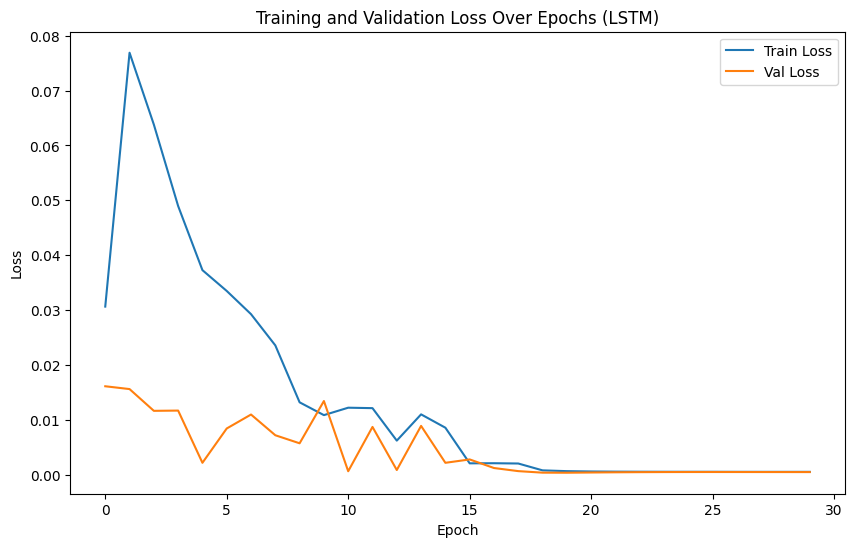

In [ ]:
# ---------------------------------------
# 9. Retrain Final Model with Best Hyperparams
# ---------------------------------------
best_params = study.best_params
model = LSTMModel(input_dim=len(features), hidden_dim=best_params['hidden_dim'], output_dim=len(features)).to(device)
criterion = AsymmetricLoss(ratio=best_params['asymmetric_ratio'])
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5)

best_state, _, train_losses, val_losses = train_and_validate(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=30)
model.load_state_dict(best_state)

# Plot training vs validation loss to check for overfitting
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss Over Epochs (LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Predicted (first 5):
 [[773.905   781.57794 767.31384 768.63904]
 [777.7077  785.6011  771.35614 776.5633 ]
 [783.07855 791.2007  776.88513 780.477  ]
 [784.3531  792.50305 778.1743  785.6066 ]
 [794.38605 802.8475  788.47833 795.899  ]]
Actual (first 5):
 [[778.81 789.63 775.8  786.14]
 [788.36 791.34 783.16 786.9 ]
 [786.08 794.48 785.02 794.02]
 [795.26 807.9  792.2  806.15]
 [806.4  809.97 802.83 806.65]]
Test MSE: 105.9334, RMSE: 10.2924, MAE: 8.8954


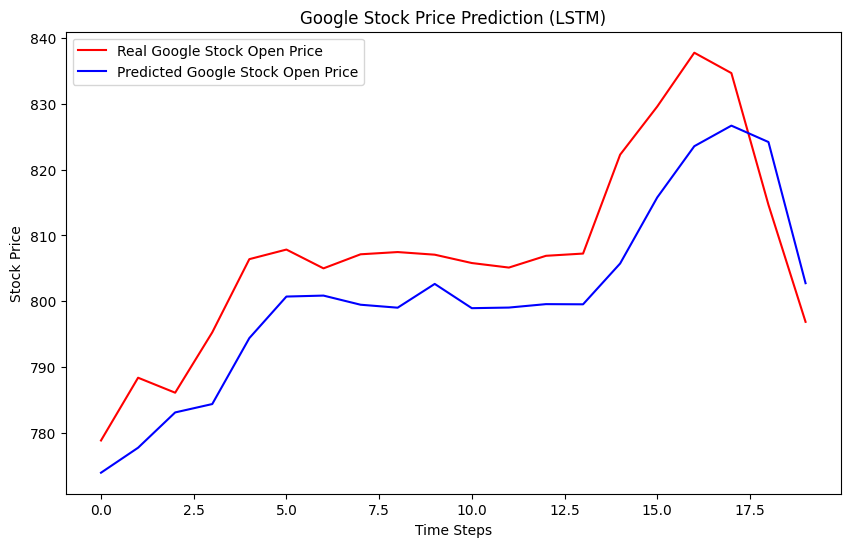

In [ ]:
# ---------------------------------------
# 10. Evaluate on Test Set
# ---------------------------------------
# Ensure proper alignment by taking last N days of training plus test data
test_input = np.concatenate((training_set[-N:], test_set), axis=0)
test_input_scaled = scaler.transform(test_input)

X_test = []
for i in range(N, len(test_input_scaled)):
    X_test.append(test_input_scaled[i-N:i, :])
X_test = np.array(X_test)
X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    predicted_scaled = model(X_test_torch).cpu().numpy()

predicted_stock_price = scaler.inverse_transform(predicted_scaled.reshape(-1, len(features)))
real_prices = test_data[features].values

print("Predicted (first 5):\n", predicted_stock_price[:5])
print("Actual (first 5):\n", real_prices[:5])

# Compute Evaluation Metrics
mse = mean_squared_error(real_prices[:len(predicted_stock_price), :], predicted_stock_price)
rmse = np.sqrt(mse)
mae = mean_absolute_error(real_prices[:len(predicted_stock_price), :], predicted_stock_price)
print(f"Test MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# Focus on 'Open' price for visualization
real_open_price = real_prices[:len(predicted_stock_price), 0]
predicted_open_price = predicted_stock_price[:, 0]

# Plot predicted vs real prices
plt.figure(figsize=(10,6))
plt.plot(real_open_price, color='red', label='Real Google Stock Open Price')
plt.plot(predicted_open_price, color='blue', label='Predicted Google Stock Open Price')
plt.title('Google Stock Price Prediction (LSTM)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

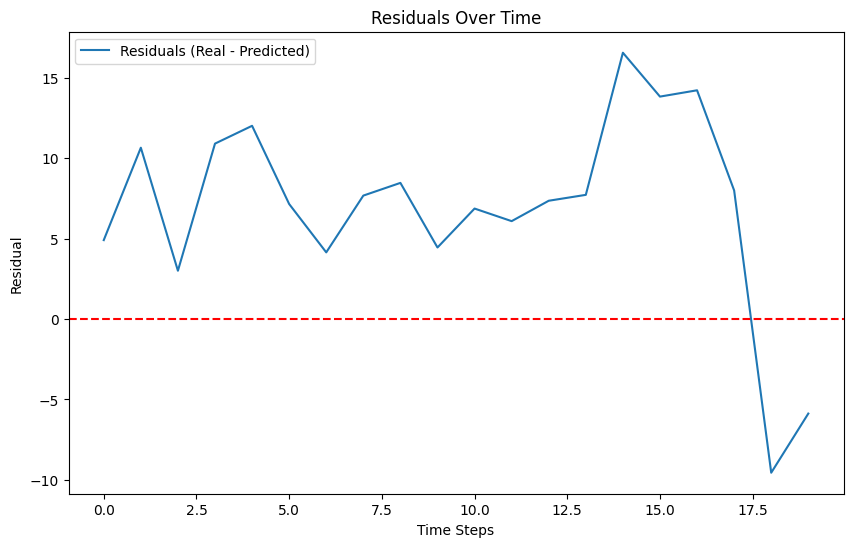

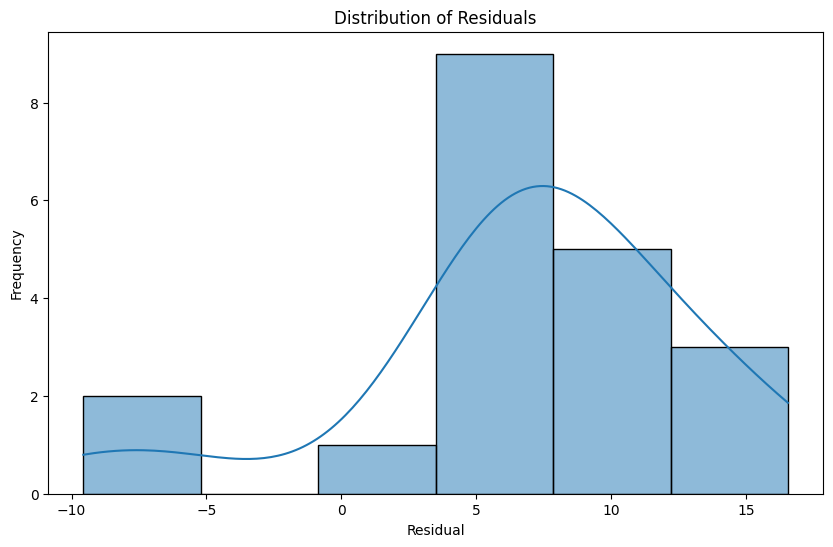

In [ ]:
# ---------------------------------------
# 11. Residual Analysis (Check for Systematic Bias)
# ---------------------------------------
residuals = real_open_price - predicted_open_price

# Plot residuals over time
plt.figure(figsize=(10,6))
plt.plot(residuals, label='Residuals (Real - Predicted)')
plt.title('Residuals Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Residual')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend()
plt.show()

# Distribution of residuals
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()


